In [83]:
using Gen
using Plots
include("./distribution_utils.jl")

has_argument_grads (generic function with 1 method)

In [74]:
struct FireflyState
    x::Float64
    y::Float64
    vx::Float64
    vy::Float64
    blinking::Int64
    blink_rate::Float64
end

In [201]:
@gen (static) function init_single_state()
    x = {:x} ~ uniform(1, 64)
    y = {:y} ~ uniform(1, 64)
    vx = {:vx} ~ normal(0, 1)
    vy = {:vy} ~ normal(0, 1)
    blinking = {:blinking} ~ bernoulli(0.5)
    blink_rate = {:blink_rate} ~ uniform(0.05, 0.15)
    return FireflyState(x, y, vx, vy, blinking, blink_rate)
end

@gen (static) function reverse_velocity(v::Float64)
    return normal(-v, 0.1)
end

@gen (static) function maintain_velocity(v::Float64)
    return normal(v, 0.1)
end

update_velocity = Switch(maintain_velocity, reverse_velocity)

@gen (static) function update_single_state(t::Int64, prev_state::FireflyState, scene_dim::Int64)
    prev_x = prev_state.x
    prev_y = prev_state.y
    prev_vx = prev_state.vx
    prev_vy = prev_state.vy
    vx ~ update_velocity(prev_x + prev_vx > scene_dim - 1 || prev_x + prev_vx < 2)
    vy ~  update_velocity(prev_y + prev_vy > scene_dim - 1 || prev_y + prev_vy < 2)
    
    x ~ trunc_norm(prev_x + vx, .1, 1., Float64(scene_dim))
    y ~ trunc_norm(prev_y + vy, .1, 1., Float64(scene_dim))

    blinking ~ bernoulli(prev_state.blink_rate)
    return FireflyState(x, y, vx, vy, blinking, prev_state.blink_rate)
end

init_all_states = Map(init_single_state)
chain_states_single = Unfold(update_single_state)
chain_states = Map(chain_states_single)

Gen.@load_generated_functions

LoadError: LoadError: Syntax error when parsing static DSL function at if position < 4 || position > 62
    #= In[201]:13 =#
    velocity = -velocity
end. Unsupported top-level construct.
in expression starting at In[201]:11

In [198]:
@gen (static) function unfold_model(T::Int, scene_size::Int)
    num ~ uniform_discrete(1, 4)
    
    init_states = init_all_states(ones(num))
    states ~ chain_states(fill(T, num), init_states, fill(scene_size, num))

    return num, states
end

Gen.@load_generated_functions

In [199]:
# Animate a plot of the firefly states
function animate_firefly_states(trace; fps::Int64 = 10)
    steps, scene_size = get_args(trace)
    num, _ = get_retval(trace)
    choices = get_choices(trace)
    num = choices[:num]
    
    fig = plot()
    anim = Plots.@animate for t=1:steps
        empty!(fig)
        xlims!(0, scene_size)
        ylims!(0, scene_size)

        for i=1:num
            blinking = choices[:states => i => t => :blinking]
            x = choices[:states => i => t => :x]
            y = choices[:states => i => t => :y]
            markershape = blinking ? :circle : :x
            color = blinking ? :yellow : :purple
            scatter!([x], [y], markershape=markershape, markersize=10, color=color, legend=false, background_color=:black)
        end
    end

    gif(anim, "firefly.gif", fps=fps)
end

animate_firefly_states (generic function with 2 methods)

In [200]:
get_choices(trace)

│
├── :num : 4
│
└── :states
    │
    ├── 1
    │   │
    │   ├── 1
    │   │   │
    │   │   ├── :vy : -0.14470067785324425
    │   │   │
    │   │   ├── :x : 54.768168913096986
    │   │   │
    │   │   ├── :y : 1.368049155028806
    │   │   │
    │   │   ├── :blinking : false
    │   │   │
    │   │   └── :vx
    │   │
    │   ├── 2
    │   │   │
    │   │   ├── :vy : -1.3328907616350454
    │   │   │
    │   │   ├── :x : 54.216217035934214
    │   │   │
    │   │   ├── :y : 1.0029076617083987
    │   │   │
    │   │   ├── :blinking : false
    │   │   │
    │   │   └── :vx
    │   │
    │   ├── 3
    │   │   │
    │   │   ├── :vy : -1.5154763845918737
    │   │   │
    │   │   ├── :x : 53.66609754035755
    │   │   │
    │   │   ├── :y : 1.0007123270816194
    │   │   │
    │   │   ├── :blinking : false
    │   │   │
    │   │   └── :vx
    │   │
    │   ├── 4
    │   │   │
    │   │   ├── :vy : -3.1401280065049364
    │   │   │
    │   │   ├── :x : 53.096523028268265
    │   │   

[ Info: Saved animation to /Users/yonifriedman/Research/ProbComp/Fireflies/firefly.gif


Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/firefly.gif")
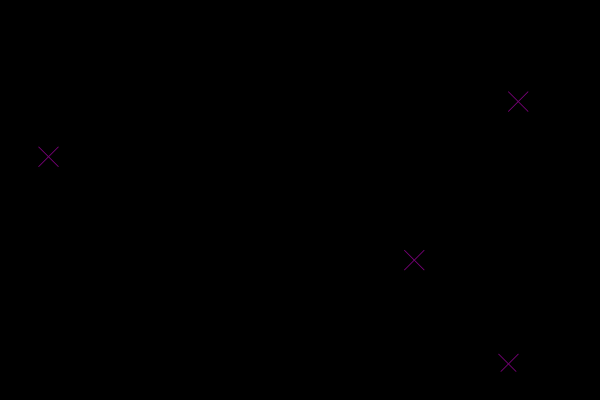

In [194]:
trace = simulate(unfold_model, (60, 64,))
animate_firefly_states(trace, fps=10)